# Modelling

## Import relevant libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import recall_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, accuracy_score
from sklearn.metrics import precision_recall_curve, auc, f1_score, precision_score, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

# 1. Load preprocessed data

In [2]:
df = pd.read_csv('Data/preprocessed_train_churn.csv')
print(df.shape)
df.head()

(4250, 12)


,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn,total_net_minutes,total_net_calls,total_net_charge
0,107,0,1,26.0,13.7,3.0,3.70,1,0,611.50,329.0,55.540
1,137,0,0,0.0,12.2,5.0,3.29,0,0,527.20,328.0,59.000
2,84,1,0,0.0,6.6,7.0,1.78,2,0,560.45,248.0,65.215
3,75,1,0,0.0,10.1,3.0,2.73,3,0,501.90,356.0,49.360
4,121,0,1,24.0,7.5,7.0,2.03,3,0,766.35,314.0,75.175


## 1.1 Divide data features/target

In [3]:
y = df['churn']
X = df.drop('churn',
            axis=1)

In [4]:
X_train , X_test , y_train , y_test = train_test_split(X ,
                                                       y,
                                                       test_size = 0.20,
                                                       random_state = 42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3400, 11)
(3400,)
(850, 11)
(850,)


# 2. Models training

First of all, let's define some functions to help evaluate models:

In [5]:
models = []
accuracies = []
recalls = []
precisions = []
f1_scores = []
cross_val_scores = []

In [6]:
def model_evaluation(X_train, y_train, X_test, y_test, y_pred, classifier, model_name):
    acc = round(accuracy_score(y_test, y_pred), 3)
    prec = round(precision_score(y_test, y_pred, average="micro"), 3)
    recall = round(recall_score(y_test, y_pred), 3)
    f1_s = round(f1_score(y_test, y_pred), 3)
    c_val_score = round(cross_val_score(classifier, X_train, y_train, cv=10, scoring='accuracy').mean(), 3)
    
    # metrics printing
    print(f'Accuracy Score is: {acc}')
    print(f'Precision Score is: {prec}')
    print(f'Recall Score is: {recall}')
    print(f'F1 Score is: {f1_s}')
    print(f'Cross-Validation Score is: {c_val_score}')
    
    models.append(model_name)
    accuracies.append(acc)
    recalls.append(recall)
    precisions.append(prec)
    f1_scores.append(f1_s)
    cross_val_scores.append(c_val_score)
    
    print(classification_report(y_test, y_pred))

In [7]:
def feature_weights(X_df, classifier, classifier_name):
    if hasattr(classifier, 'coef_'):
        # For linear models like Logistic Regression
        weights = round(pd.Series(classifier.coef_[0], index=X_df.columns.values).sort_values(ascending=False), 2)
        
    elif hasattr(classifier, 'feature_importances_'):
        # For models with feature importances like Decision Trees or Random Forests
        weights = round(pd.Series(classifier.feature_importances_, index=X_df.columns.values).sort_values(ascending=False), 2)
        
    else:
        # Handle other cases or raise an exception
        raise AttributeError(f'{classifier_name} does not have attribute for feature weights.')

    top_weights_selected = weights[:5]
    
    plt.figure(figsize=(7, 6))
    plt.tick_params(labelsize=10)
    plt.title(f'{classifier_name} - Top 5 Features')
    
    ax = top_weights_selected.plot(kind="bar")
    ax.bar_label(ax.containers[0])

In [8]:
def confusion_matrix_plot(X_test, y_test, classifier, classifier_name):
    y_pred = classifier.predict(X_test)
    
    ax = confusion_matrix(y_test,
                          y_pred,
                          labels=classifier.classes_)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(ax, annot=True, fmt="d", cmap="Blues", xticklabels=["No Churn", "Churn"], yticklabels=["No Churn", "Churn"])
    plt.title(f'Confusion Matrix - {classifier_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

## 2.1 Logistic Regression

In [9]:
model_lr= LogisticRegression(random_state=42)  
model_lr.fit(X_train, y_train) 
y_pred = model_lr.predict(X_test)
model_lr.score(X_test , y_test)

0.8470588235294118

Accuracy Score is: 0.847
Precision Score is: 0.847
Recall Score is: 0.132
F1 Score is: 0.207
Cross-Validation Score is: 0.862
              precision    recall  f1-score   support

           0       0.86      0.98      0.92       721
           1       0.49      0.13      0.21       129

    accuracy                           0.85       850
   macro avg       0.67      0.55      0.56       850
weighted avg       0.81      0.85      0.81       850



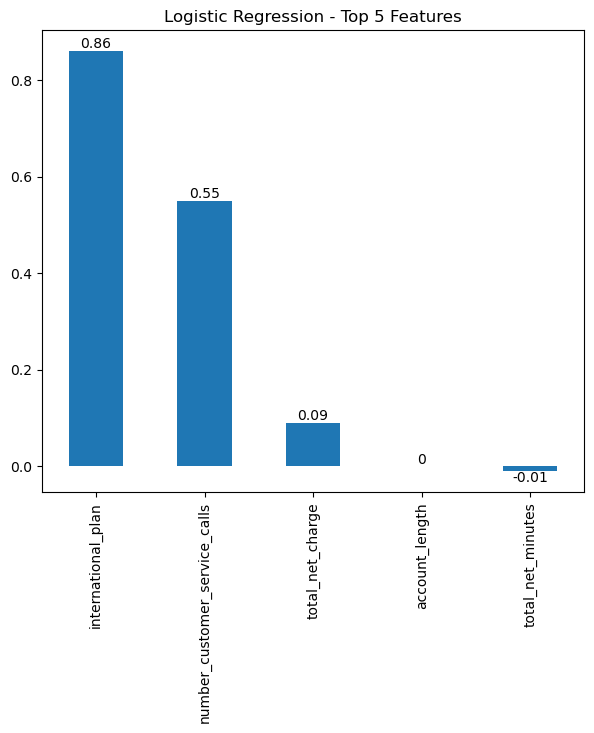

In [10]:
model_evaluation(X_train, y_train ,
               X_test, y_test ,
               y_pred , model_lr,
               "Logistic Reegression") 

feature_weights(X_train,
                model_lr,
                "Logistic Regression")

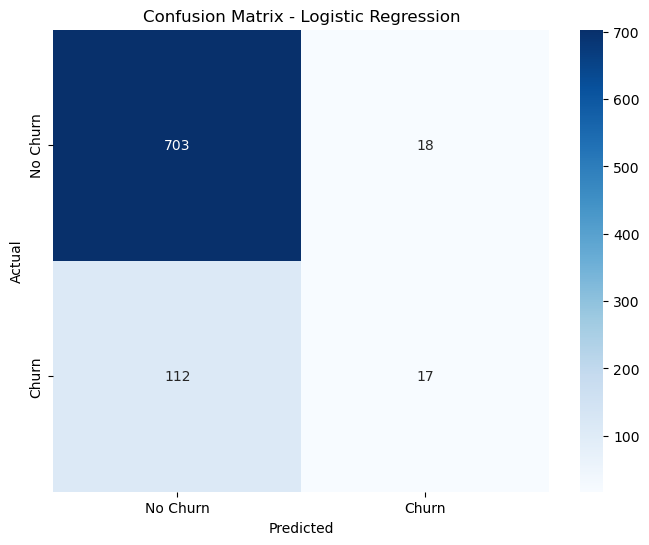

In [11]:
confusion_matrix_plot(X_test,
                      y_test,
                      model_lr,
                      "Logistic Regression")

## 2.2 Support Vector Machine

In [12]:
svm = SVC(kernel='rbf',
          probability=True,
          random_state=42) 
svm.fit(X_train,
        y_train)

# Make predictions (classes and probabilities) with the trained model on the test set.
y_pred = svm.predict(X_test)
svm.score(X_test,
          y_test) 

0.8482352941176471

In [13]:
model_evaluation(X_train, y_train,
                 X_test, y_test,
                 y_pred, svm,
                 'Support Vector Machine')

Accuracy Score is: 0.848
Precision Score is: 0.848
Recall Score is: 0.0
F1 Score is: 0.0
Cross-Validation Score is: 0.862
              precision    recall  f1-score   support

           0       0.85      1.00      0.92       721
           1       0.00      0.00      0.00       129

    accuracy                           0.85       850
   macro avg       0.42      0.50      0.46       850
weighted avg       0.72      0.85      0.78       850



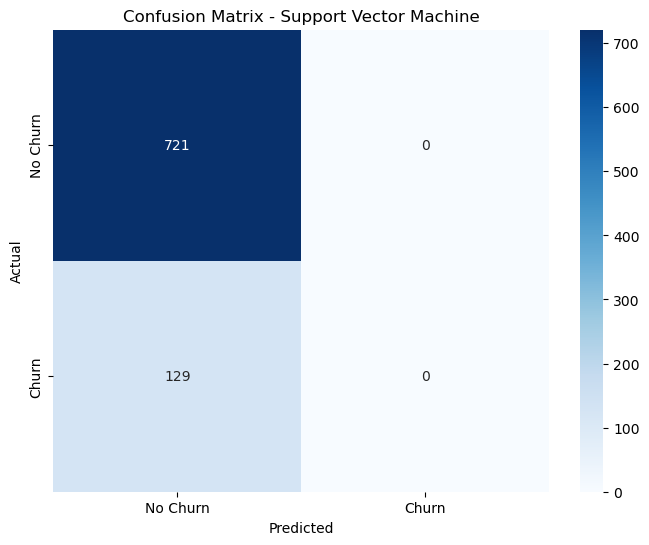

In [14]:
confusion_matrix_plot(X_test,
                      y_test,
                      svm,
                      'Support Vector Machine')

## 2.3 Decision Tree

In [15]:
dtc = DecisionTreeClassifier(random_state=42)

dtc.fit(X_train,
        y_train)
y_pred = dtc.predict(X_test)

dtc.score(X_test , y_test) 

0.9435294117647058

Accuracy Score is: 0.944
Precision Score is: 0.944
Recall Score is: 0.853
F1 Score is: 0.821
Cross-Validation Score is: 0.949
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       721
           1       0.79      0.85      0.82       129

    accuracy                           0.94       850
   macro avg       0.88      0.91      0.89       850
weighted avg       0.95      0.94      0.94       850



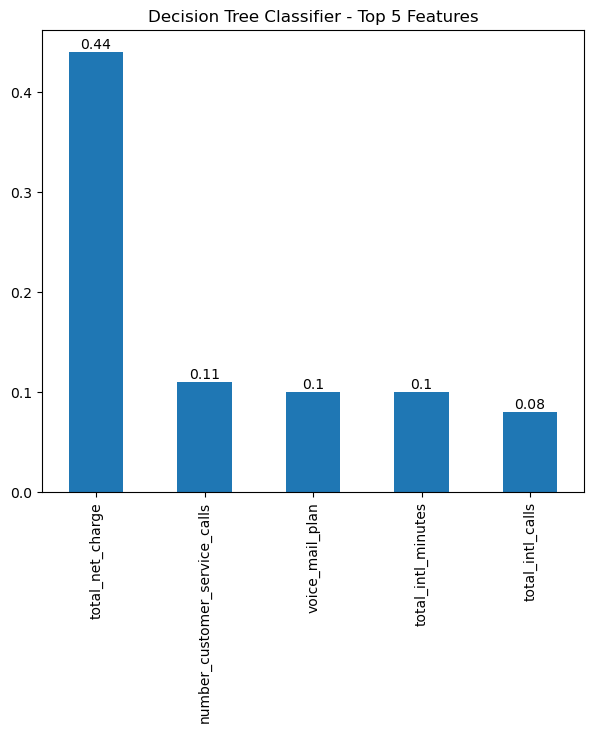

In [16]:
model_evaluation(X_train, y_train,
                 X_test, y_test,
                 y_pred, dtc,
                 'Decision Tree Classifier')

feature_weights(X_train,
                dtc,
                'Decision Tree Classifier')

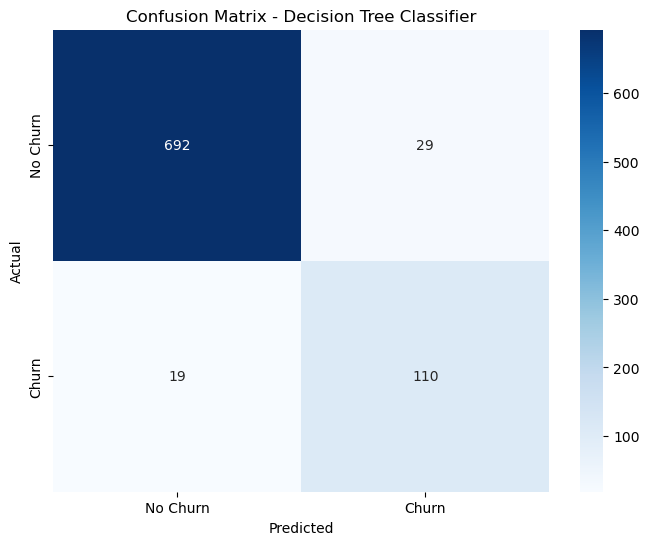

In [17]:
confusion_matrix_plot(X_test,
                      y_test,
                      dtc,
                      'Decision Tree Classifier')

## 2.4 Random Forest

In [18]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

rf.score(X_test , y_test) 

0.9764705882352941

Accuracy Score is: 0.976
Precision Score is: 0.976
Recall Score is: 0.868
F1 Score is: 0.918
Cross-Validation Score is: 0.974
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       721
           1       0.97      0.87      0.92       129

    accuracy                           0.98       850
   macro avg       0.98      0.93      0.95       850
weighted avg       0.98      0.98      0.98       850



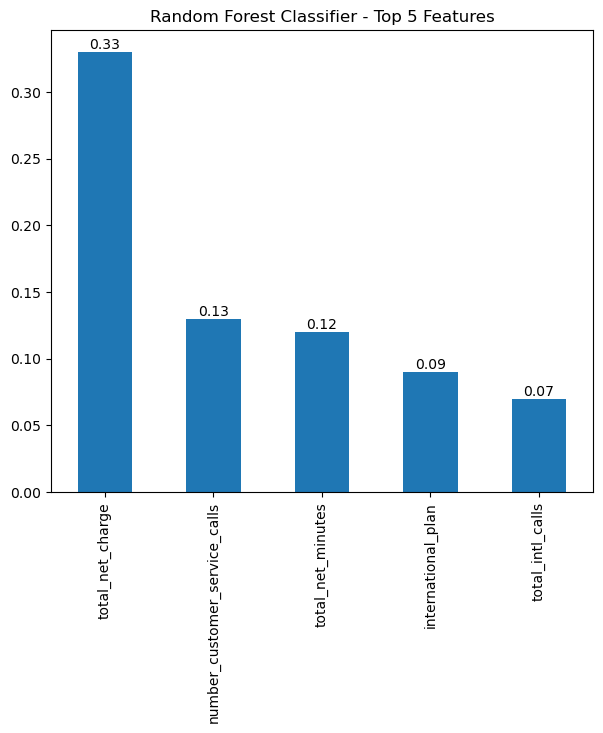

In [19]:
model_evaluation(X_train, y_train,
                 X_test, y_test,
                 y_pred, rf,
                 'Random Forest Classifier')

feature_weights(X_train,
                rf,
                'Random Forest Classifier')

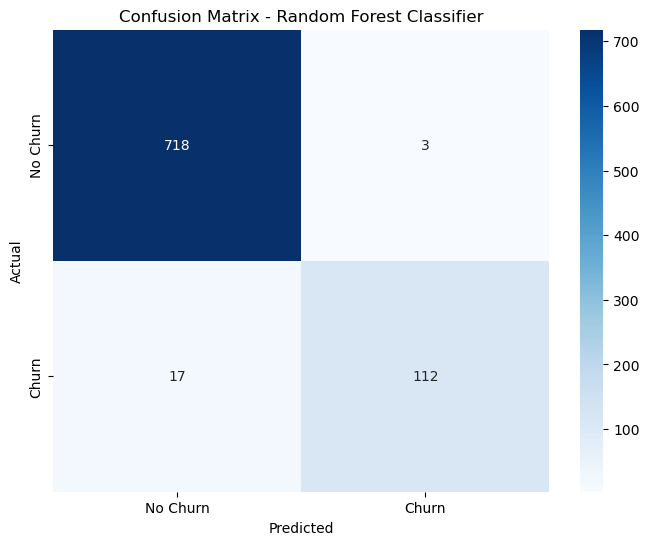

In [20]:
confusion_matrix_plot(X_test,
                      y_test,
                      rf,
                      'Random Forest Classifier')

## 2.5 Gradient Boosting

In [21]:
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)

y_pred = gb.predict(X_test)
gb.score(X_test, y_test)

0.9694117647058823

Accuracy Score is: 0.969
Precision Score is: 0.969
Recall Score is: 0.868
F1 Score is: 0.896
Cross-Validation Score is: 0.972
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       721
           1       0.93      0.87      0.90       129

    accuracy                           0.97       850
   macro avg       0.95      0.93      0.94       850
weighted avg       0.97      0.97      0.97       850



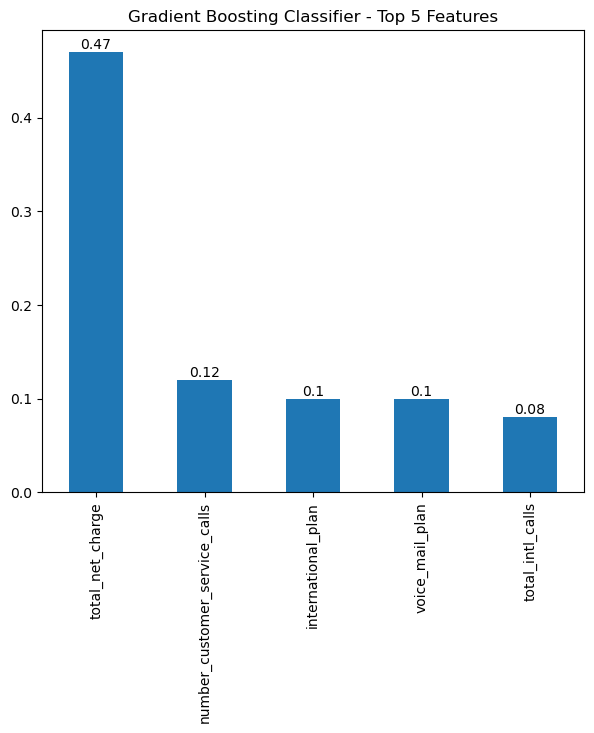

In [22]:
model_evaluation(X_train, y_train,
                 X_test, y_test,
                 y_pred, gb,
                 'Gradient Boosting Classifier')

feature_weights(X_train,
                gb,
                'Gradient Boosting Classifier')

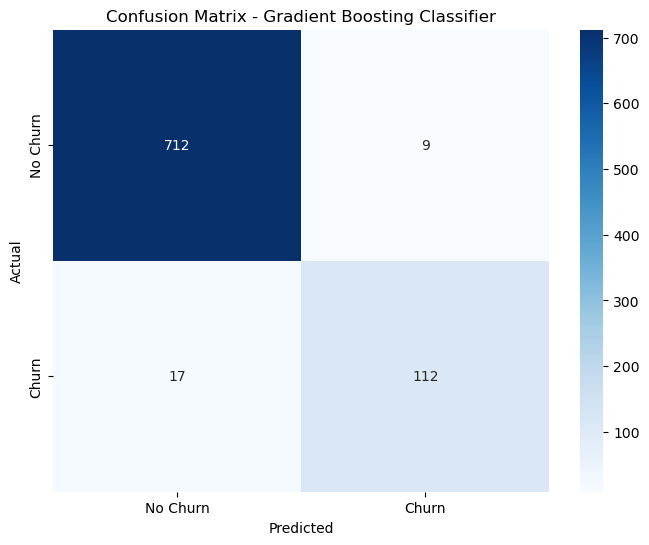

In [23]:
confusion_matrix_plot(X_test,
                      y_test,
                      gb,
                      'Gradient Boosting Classifier')

In [24]:
dict = {'Model':models,
        'Accuracy':accuracies,
        'Precision':precisions,
        'f1_score':f1_scores,
        'Recall':recalls ,
        'Cross_Val_Score':cross_val_scores}

model_df = pd.DataFrame(dict).sort_values(ascending = False,
                                          by = 'Accuracy')
model_df 

,Model,Accuracy,Precision,f1_score,Recall,Cross_Val_Score
3,Random Forest Classifier,0.976,0.976,0.918,0.868,0.974
4,Gradient Boosting Classifier,0.969,0.969,0.896,0.868,0.972
2,Decision Tree Classifier,0.944,0.944,0.821,0.853,0.949
1,Support Vector Machine,0.848,0.848,0.000,0.000,0.862
0,Logistic Reegression,0.847,0.847,0.207,0.132,0.862


# 3. Hyperparameter tuning

## 3.1 Logistic Regression

In [25]:
lr_params = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2']
}

lr_grid = GridSearchCV(LogisticRegression(random_state=42),
                       lr_params,
                       cv=5,
                       scoring='accuracy')

lr_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
             param_grid={'C': [0.1, 1, 10], 'penalty': ['l1', 'l2']},
             scoring='accuracy')

In [26]:
print("Logistic Regression Best Params:", lr_grid.best_params_)
print("Logistic Regression Test Accuracy:", lr_grid.best_estimator_.score(X_test, y_test))

Logistic Regression Best Params: {'C': 1, 'penalty': 'l2'}
Logistic Regression Test Accuracy: 0.8470588235294118


## 3.2 Support Vector Machine

In [27]:
svm_params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

svm_grid = GridSearchCV(SVC(random_state=42),
                        svm_params,
                        cv=5,
                        scoring='accuracy')
svm_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(random_state=42),
             param_grid={'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf']},
             scoring='accuracy')

In [28]:
print("Support Vector Machine Best Params:", svm_grid.best_params_)
print("Support Vector Machine Test Accuracy:", svm_grid.best_estimator_.score(X_test, y_test))

Support Vector Machine Best Params: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Support Vector Machine Test Accuracy: 0.8635294117647059


## 3.3 Decision Tree Classifier

In [29]:
dtc_params = {
    'max_depth': [1, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

dtc_grid = GridSearchCV(DecisionTreeClassifier(random_state=42),
                        dtc_params,
                        cv=5,
                        scoring='accuracy')
dtc_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [1, 5, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy')

In [30]:
print("Decision Tree Classifier Best Params:", dtc_grid.best_params_)
print("Decision Tree Classifier Test Accuracy:", dtc_grid.best_estimator_.score(X_test, y_test))

Decision Tree Classifier Best Params: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
Decision Tree Classifier Test Accuracy: 0.9705882352941176


## 3.4 Random Forest

In [31]:
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [1, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_grid = GridSearchCV(RandomForestClassifier(random_state=42),
                       rf_params,
                       cv=5,
                       scoring='accuracy')
rf_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [1, 5, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [32]:
print("Random Forest Best Params:", rf_grid.best_params_)
print("Random Forest Test Accuracy:", rf_grid.best_estimator_.score(X_test, y_test))

Random Forest Best Params: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Random Forest Test Accuracy: 0.9752941176470589


## 3.5 Gradient Boosting

In [33]:
gb_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

gb_grid = GridSearchCV(GradientBoostingClassifier(random_state=42),
                       gb_params,
                       cv=5,
                       scoring='accuracy')
gb_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [34]:
print("Gradient Boosting Best Params:", gb_grid.best_params_)
print("Gradient Boosting Test Accuracy:", gb_grid.best_estimator_.score(X_test, y_test))

Gradient Boosting Best Params: {'learning_rate': 0.2, 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Gradient Boosting Test Accuracy: 0.9764705882352941


# 4. Testing tuned models

## 4.1 Logistic regression

In [35]:
new_model_lr= LogisticRegression(**lr_grid.best_params_,
                                 random_state=42)  
new_model_lr.fit(X_train, y_train) 
y_pred = new_model_lr.predict(X_test)
new_model_lr.score(X_test , y_test)

0.8470588235294118

In [36]:
model_evaluation(X_train, y_train ,
               X_test, y_test ,
               y_pred , new_model_lr,
               "Tuned Logistic Reegression") 

Accuracy Score is: 0.847
Precision Score is: 0.847
Recall Score is: 0.132
F1 Score is: 0.207
Cross-Validation Score is: 0.862
              precision    recall  f1-score   support

           0       0.86      0.98      0.92       721
           1       0.49      0.13      0.21       129

    accuracy                           0.85       850
   macro avg       0.67      0.55      0.56       850
weighted avg       0.81      0.85      0.81       850



## 4.2 Support Vector Machine

In [37]:
new_svm = SVC(**svm_grid.best_params_,
              random_state=42) 
new_svm.fit(X_train,
            y_train)

# Make predictions (classes and probabilities) with the trained model on the test set.
y_pred = new_svm.predict(X_test)
new_svm.score(X_test,
              y_test) 

0.8635294117647059

In [38]:
model_evaluation(X_train, y_train ,
               X_test, y_test ,
               y_pred , new_svm,
               "Tuned Support Vector Machine") 

Accuracy Score is: 0.864
Precision Score is: 0.864
Recall Score is: 0.209
F1 Score is: 0.318
Cross-Validation Score is: 0.868
              precision    recall  f1-score   support

           0       0.87      0.98      0.92       721
           1       0.66      0.21      0.32       129

    accuracy                           0.86       850
   macro avg       0.77      0.59      0.62       850
weighted avg       0.84      0.86      0.83       850



## 4.3 Decision Tree

In [39]:
new_dtc = DecisionTreeClassifier(**dtc_grid.best_params_,
                                 random_state=42)

new_dtc.fit(X_train,
        y_train)
y_pred = new_dtc.predict(X_test)

new_dtc.score(X_test , y_test) 

0.9705882352941176

In [40]:
model_evaluation(X_train, y_train ,
               X_test, y_test ,
               y_pred , new_dtc,
               "Tuned Decision Tree Classifier") 

Accuracy Score is: 0.971
Precision Score is: 0.971
Recall Score is: 0.845
F1 Score is: 0.897
Cross-Validation Score is: 0.971
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       721
           1       0.96      0.84      0.90       129

    accuracy                           0.97       850
   macro avg       0.96      0.92      0.94       850
weighted avg       0.97      0.97      0.97       850



## 4.4 Random Forest

In [41]:
new_rf = RandomForestClassifier(**rf_grid.best_params_,
                                random_state=42)
new_rf.fit(X_train, y_train)

y_pred = new_rf.predict(X_test)

new_rf.score(X_test , y_test) 

0.9752941176470589

In [42]:
model_evaluation(X_train, y_train,
                 X_test, y_test,
                 y_pred, new_rf,
                 'Tuned Random Forest Classifier')

Accuracy Score is: 0.975
Precision Score is: 0.975
Recall Score is: 0.86
F1 Score is: 0.914
Cross-Validation Score is: 0.973
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       721
           1       0.97      0.86      0.91       129

    accuracy                           0.98       850
   macro avg       0.97      0.93      0.95       850
weighted avg       0.98      0.98      0.97       850



## 4.5 Gradient Boosting

In [43]:
new_gb = GradientBoostingClassifier(**gb_grid.best_params_,
                                    random_state=42)
new_gb.fit(X_train, y_train)

y_pred = new_gb.predict(X_test)
new_gb.score(X_test, y_test)

0.9764705882352941

In [44]:
model_evaluation(X_train, y_train,
                 X_test, y_test,
                 y_pred, new_gb,
                 'Tuned Gradient Boosting Classifier')


Accuracy Score is: 0.976
Precision Score is: 0.976
Recall Score is: 0.876
F1 Score is: 0.919
Cross-Validation Score is: 0.975
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       721
           1       0.97      0.88      0.92       129

    accuracy                           0.98       850
   macro avg       0.97      0.94      0.95       850
weighted avg       0.98      0.98      0.98       850



In [45]:
dict = {'Model': models,
        'Accuracy': accuracies,
        'Precision':precisions,
        'f1_score': f1_scores,
        'Recall': recalls ,
        'Cross_Val_Score': cross_val_scores}

model_df = pd.DataFrame(dict).sort_values(ascending = False,
                                          by = 'Accuracy')
model_df 

,Model,Accuracy,Precision,f1_score,Recall,Cross_Val_Score
3,Random Forest Classifier,0.976,0.976,0.918,0.868,0.974
9,Tuned Gradient Boosting Classifier,0.976,0.976,0.919,0.876,0.975
8,Tuned Random Forest Classifier,0.975,0.975,0.914,0.860,0.973
7,Tuned Decision Tree Classifier,0.971,0.971,0.897,0.845,0.971
4,Gradient Boosting Classifier,0.969,0.969,0.896,0.868,0.972
2,Decision Tree Classifier,0.944,0.944,0.821,0.853,0.949
6,Tuned Support Vector Machine,0.864,0.864,0.318,0.209,0.868
1,Support Vector Machine,0.848,0.848,0.000,0.000,0.862
0,Logistic Reegression,0.847,0.847,0.207,0.132,0.862
5,Tuned Logistic Reegression,0.847,0.847,0.207,0.132,0.862


There is improvement in most of the models except for random forest classifier, so, as conclussion, it's a waste of time trying to tune models hyperparameters.

In the end, we have an accuracy of 97.6%, which is a good result and maybe it could be improved in the preprocessing step.